In [117]:
import os
import time
import numpy as np
import numpy.random as npr
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma

assert os.path.exists("/Users/daany/Downloads/HT/LDA/ap.txt") and os.path.exists("/Users/daany/Downloads/HT/LDA/vocab.txt")

with open("vocab.txt", "r") as f:
    vocab = set(f.read().splitlines())

with open("ap.txt", "r") as f:
    raw_text = f.read()

texts = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
stop_words = set(stopwords.words("english"))
documents = []

for text in texts:
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word in vocab]
    documents.append(tokens)

N = len(documents)
V = len(vocab)

doc_term_matrix = np.zeros((N, V))
vocab_to_index = {word: i for i, word in enumerate(vocab)}

for doc_idx, tokens in enumerate(documents):
    token_counts = Counter(tokens)
    for token, count in token_counts.items():
        if token in vocab_to_index:
            term_idx = vocab_to_index[token]
            doc_term_matrix[doc_idx, term_idx] = count

nonzero_idxs = []
for doc in doc_term_matrix:
    nonzero_idx = np.where(doc > 0)[0]
    nonzero_idxs.append(sorted(nonzero_idx))

ETA = 1 / V
ALPHA = 0.5
K = 30 

def init_variational_params(doc_term_matrix, K, rand_state=0):
    N, V = doc_term_matrix.shape # N is number of documents
    # rs = npr.RandomState(rand_state)
    # LAMBDA = rs.random(size=(K, V)) + 0.001
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in doc_term_matrix:
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_p_z_x += doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:, idx]) - digamma(np.sum(LAMBDA, axis=1))))
            corr_idx += 1
    ELBO += E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_z += -doc[idx] * np.sum(PHI[i][corr_idx] * np.log(PHI[i][corr_idx]))
            corr_idx += 1
    ELBO += E_q_log_z

    return ELBO

def log_sum_exp(vec):
    a = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - a))) + a

    return log_sum_exp

def update_variational_params(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape

    print("Updating PHI and GAMMA")
    for i in tqdm(range(N)):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((K, ))
            for k in range(K):
                exponent = digamma(GAMMA[i][k]) - digamma(np.sum(GAMMA[i])) \
                    + digamma(LAMBDA[k][idx]) - digamma(np.sum(LAMBDA[k]))
                log_PHI_ij[k] = exponent
            PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
            PHI[i][corr_idx] = PHI_ij
            corr_idx += 1

        GAMMA_i = np.zeros((K, )) + ALPHA
        for k in range(K):
            GAMMA_i[k] += np.sum(doc[nonzero_idx] * PHI[i][:, k])
        GAMMA[i] = GAMMA_i

    print("Updating LAMBDA")
    for k in tqdm(range(K)):
        LAMBDA_k = np.zeros((V, )) + ETA
        for i in range(N):
            doc = doc_term_matrix[i]
            nonzero_idx = nonzero_idxs[i]
            corr_idx = 0
            for idx in nonzero_idx:
                LAMBDA_k[idx] += PHI[i][corr_idx][k]
                corr_idx += 1
        LAMBDA[k] = LAMBDA_k

    return LAMBDA, GAMMA, PHI

In [134]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]

with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

stop_words = set(stopwords.words("english"))
corpus_matrix = []
for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_idxs = [vocab_to_idx[word] for word in filtered_tokens if word in vocab_to_idx]
    corpus_matrix.append(word_idxs)

In [472]:
def init_variational_params(corpus_matrix, K, V):
    N = len(corpus_matrix)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in corpus_matrix:
        doc = np.asarray(doc)
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = 0
    for k in range(K):
        E_q_log_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_q_log_BETA

    E_q_log_THETA = 0
    for i in range(N):
        E_q_log_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j]))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    for i, doc in enumerate(tqdm(corpus_matrix, desc="Updating LAMBDA")):
        PHI_doc = PHI[i]
        for j, word in enumerate(doc):
            LAMBDA[:, word] += PHI_doc[j, :]

    ETA_matrix = np.full((K, V), ETA)
    LAMBDA = LAMBDA + ETA_matrix

    return LAMBDA, GAMMA, PHI

In [272]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-7:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

top_words

{0: ['party', 'court', 'percent', 'police', 'gorbachev', 'states', 'two'],
 1: ['percent', 'new', 'two', 'company', 'president', 'york', 'time'],
 2: ['soviet', 'state', 'million', 'first', 'new', 'department', 'government'],
 3: ['year', 'today', 'york', 'says', 'spokesman', 'monday', 'market'],
 4: ['new', 'time', 'united', 'million', 'soviet', 'world', 'told'],
 5: ['year', 'million', 'years', 'today', 'two', 'dukakis', 'house'],
 6: ['united', 'bush', 'president', 'states', 'soviet', 'reagan', 'national'],
 7: ['percent', 'new', 'people', 'million', 'year', 'two', 'government'],
 8: ['last', 'state', 'two', 'year', 'officials', 'government', 'first'],
 9: ['party', 'united', 'defense', 'case', 'expected', 'day', 'money'],
 10: ['cdy', 'clr', 'rn', 'company', 'million', 'first', 'two'],
 11: ['percent', 'time', 'bush', 'billion', 'friday', 'police', 'million'],
 12: ['people', 'officials', 'percent', 'years', 'today', 'back', 'american'],
 13: ['new', 'year', 'national', 'friday', '

In [374]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]
stop_words = set(stopwords.words("english"))
word_counts = Counter()
tokenized_documents = []

for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word \
                       not in stop_words]
    tokenized_documents.append(filtered_tokens)
    word_counts.update(filtered_tokens)

reduced_vocab = [word for word, _ in word_counts.most_common(1000)]
vocab_to_idx = {word: idx for idx, word in enumerate(reduced_vocab)}
reduced_corpus_matrix = []
for tokens in tokenized_documents:
    reduced_doc = [vocab_to_idx[word] for word in tokens if \
                   word in vocab_to_idx]
    if reduced_doc:
        reduced_corpus_matrix.append(reduced_doc)

In [ ]:
def init_variational_params(corpus_mat, K, V):
    N = len(corpus_mat)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = [np.ones((len(doc), K)) / K for doc in corpus_mat]

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat):
    N = len(corpus_mat)
    ELBO = 0

    E_log_p_BETA = np.sum(
        (ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True)))
        )
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum(
        (ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True)))
    )
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = np.sum(
        -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
            - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_BETA

    E_q_log_THETA = np.sum(
        -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):  # x_ij is the word index
            # PHI_nonzero = PHI[i][j][PHI[i][j] > 0]
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat, K, V):
    N= len(corpus_mat)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
    # for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    LAMBDA = np.full((K, V), ETA)
    for i, doc in enumerate(tqdm(corpus_mat, desc="Updating LAMBDA")):
    # for i, doc in enumerate(corpus_mat):
        doc_word_idxs = np.array(doc)
        for k in range(K):
            np.add.at(LAMBDA[k], doc_word_idxs, PHI[i][:, k])

    return LAMBDA, GAMMA, PHI

In [ ]:
K = 30
V = len(reduced_vocab)
ETA = 1 / V
ALPHA = 0.5

tol = 1e-2
iteration = 1
max_iterations = 100
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_mat=reduced_corpus_matrix, K=30, V=len(reduced_vocab))
ELBOs.append(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix))
while iteration <= max_iterations:
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix, K=30, V=len(reduced_vocab))
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)

    if np.abs(curr_ELBO - prev_ELBO) <= tol:
        break

    iteration += 1
    print("\n")

stop = time.time()
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)


In [457]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-10:][::-1]
    top_words[k] = [reduced_vocab[v] for v in top_idxs]

formatted_text = "Top 10 Words for Each Topic:\n\n"
for topic, words in top_words.items():
    formatted_text += f"Topic {topic + 1}: "
    formatted_text += ", ".join(words) + "\n\n"

print(formatted_text)

Top 10 Words for Each Topic:

Topic 1: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 2: iraq, less, press, robert, points, seven, western, final, continued, car

Topic 3: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 4: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 5: travel, today, company, bad, said, northwest, lines, voted, consider, guard

Topic 6: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 7: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 8: said, northwest, lines, voted, consider, ban, makes, rise, city, monday

Topic 9: people, first, officials, today, billion, thursday, court, party, day, say

Topic 10: students, northern, airport, september, spoke, history, feet, bad, said, northwest

Topic 11: said, would, new, one, also, year, two, million, president, government

Topic 12: said, northwest, lines, voted, conside

In [463]:
with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents if doc.strip()]

stop_words = set(stopwords.words("english"))
corpus_matrix = []
for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_idxs = [vocab_to_idx[word] for word in filtered_tokens if word in vocab_to_idx]
    if word_idxs:
        corpus_matrix.append(word_idxs)

In [468]:
def init_variational_params(corpus_mat, K, V):
    N = len(corpus_mat)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = [np.ones((len(doc), K)) / K for doc in corpus_mat]

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat):
    N = len(corpus_mat)
    ELBO = 0

    E_log_p_BETA = np.sum(
        (ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True)))
        )
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum(
        (ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True)))
    )
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = np.sum(
        -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
            - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_BETA

    E_q_log_THETA = np.sum(
        -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):  # x_ij is the word index
            # PHI_nonzero = PHI[i][j][PHI[i][j] > 0]
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat, K, V):
    N= len(corpus_mat)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
    # for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    LAMBDA = np.full((K, V), ETA)
    for i, doc in enumerate(tqdm(corpus_mat, desc="Updating LAMBDA")):
    # for i, doc in enumerate(corpus_mat):
        doc_word_idxs = np.array(doc)
        for k in range(K):
            np.add.at(LAMBDA[k], doc_word_idxs, PHI[i][:, k])

    return LAMBDA, GAMMA, PHI

In [477]:
def init_variational_params(corpus_matrix, K, V):
    N = len(corpus_matrix)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in corpus_matrix:
        doc = np.asarray(doc)
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = 0
    for k in range(K):
        E_q_log_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_q_log_BETA

    E_q_log_THETA = 0
    for i in range(N):
        E_q_log_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j]))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    for i, doc in enumerate(tqdm(corpus_matrix, desc="Updating LAMBDA")):
        PHI_doc = PHI[i]
        for j, word in enumerate(doc):
            LAMBDA[:, word] += PHI_doc[j, :]

    ETA_matrix = np.full((K, V), ETA)
    LAMBDA = LAMBDA + ETA_matrix

    return LAMBDA, GAMMA, PHI

Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4767.20it/s]


Current ELBO: -1012601.2095292318




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4675.16it/s]


Current ELBO: -1032581.8568762371




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4601.58it/s]


Current ELBO: -1050493.6068663409




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4797.67it/s]


Current ELBO: -1064020.563153455




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4659.89it/s]


Current ELBO: -1073438.8154795761




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4647.41it/s]


Current ELBO: -1078862.9143846568




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4205.06it/s]


Current ELBO: -1080145.4393220062




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4694.20it/s]


Current ELBO: -1076971.1333533884




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4608.19it/s]


Current ELBO: -1068985.223324927




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4606.44it/s]


Current ELBO: -1055934.3044932068




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4641.00it/s]


Current ELBO: -1037809.2610517052




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4668.53it/s]


Current ELBO: -1014961.2759435298




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3801.35it/s]


Current ELBO: -988138.3746519672




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4661.54it/s]


Current ELBO: -958403.0310917114




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4567.58it/s]


Current ELBO: -926945.6133697332




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4620.48it/s]


Current ELBO: -894863.7424508318




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4554.93it/s]


Current ELBO: -862997.2525124127




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4527.97it/s]


Current ELBO: -831874.5715628657




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4597.58it/s]


Current ELBO: -801758.4643038311




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4593.03it/s]


Current ELBO: -772742.221348474




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4698.59it/s]


Current ELBO: -744829.4595277386




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4737.81it/s]


Current ELBO: -717973.1911454825




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4747.78it/s]


Current ELBO: -692122.9772834171




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4724.23it/s]


Current ELBO: -667273.473184158




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4749.41it/s]


Current ELBO: -643437.55186416




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4661.00it/s]


Current ELBO: -620624.3438334726




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4714.84it/s]


Current ELBO: -598845.3196349009




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4613.22it/s]


Current ELBO: -578110.002828289




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4739.52it/s]


Current ELBO: -558421.5420038418




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4703.80it/s]


Current ELBO: -539767.1438996854




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4651.17it/s]


Current ELBO: -522112.2992263017




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4665.31it/s]


Current ELBO: -505410.916912109




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4733.41it/s]


Current ELBO: -489604.6548095095




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4673.01it/s]


Current ELBO: -474637.4212472914




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4607.44it/s]


Current ELBO: -460476.9358055771




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4481.71it/s]


Current ELBO: -447096.0584621278




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4608.76it/s]


Current ELBO: -434455.0188198609




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4610.21it/s]


Current ELBO: -422501.9430161171




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4696.41it/s]


Current ELBO: -411183.1387058237




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4584.16it/s]


Current ELBO: -400449.6527686295




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4623.20it/s]


Current ELBO: -390248.60312383104




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4749.70it/s]


Current ELBO: -380540.78310986713




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4716.95it/s]


Current ELBO: -371306.5956355827




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4104.00it/s]


Current ELBO: -362521.4568876464




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4396.54it/s]


Current ELBO: -354154.7671961799




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4626.33it/s]


Current ELBO: -346175.26423628314




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4303.80it/s]


Current ELBO: -338559.7809939042




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4756.71it/s]


Current ELBO: -331287.4844615792




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4579.06it/s]


Current ELBO: -324335.56136712315




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4764.71it/s]


Current ELBO: -317683.3751950983




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4631.93it/s]


Current ELBO: -311312.1892186338




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4596.93it/s]


Current ELBO: -305204.12561274145




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4673.61it/s]


Current ELBO: -299340.59512794076




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4519.01it/s]


Current ELBO: -293703.5079661988




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4695.05it/s]


Current ELBO: -288283.0865188929




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4697.48it/s]


Current ELBO: -283075.2874686958




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4659.35it/s]


Current ELBO: -278071.51543595665




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4788.11it/s]


Current ELBO: -273259.2080694666




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4750.51it/s]


Current ELBO: -268625.0633058067




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4693.00it/s]


Current ELBO: -264156.3886246635




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4636.07it/s]


Current ELBO: -259841.51303640142




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4749.09it/s]


Current ELBO: -255669.6746408977




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4650.76it/s]


Current ELBO: -251630.53903403238




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4620.76it/s]


Current ELBO: -247714.33590846596




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4314.58it/s]


Current ELBO: -243914.60117765164




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4536.47it/s]


Current ELBO: -240230.57635255685




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3898.96it/s]


Current ELBO: -236662.3235920621




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4644.60it/s]


Current ELBO: -233207.23329500394




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4569.42it/s]


Current ELBO: -229861.7971880203




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4663.00it/s]


Current ELBO: -226621.55462368543




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4427.94it/s]


Current ELBO: -223480.96930294373




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4640.75it/s]


Current ELBO: -220433.016830964




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4578.38it/s]


Current ELBO: -217470.0732619363




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4645.77it/s]


Current ELBO: -214589.64016846713




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4696.19it/s]


Current ELBO: -211793.99864997872




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3790.92it/s]


Current ELBO: -209083.3478928285




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4277.65it/s]


Current ELBO: -206454.94046386238




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3986.87it/s]


Current ELBO: -203904.8355989521




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4645.23it/s]


Current ELBO: -201428.8889497268




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4601.52it/s]


Current ELBO: -199022.9974553616




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4606.25it/s]


Current ELBO: -196683.2055632632




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4633.42it/s]


Current ELBO: -194405.9228538425




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4537.86it/s]


Current ELBO: -192188.18031569495




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4528.93it/s]


Current ELBO: -190027.74628236462




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3647.41it/s]


Current ELBO: -187922.98924276154




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4708.20it/s]


Current ELBO: -185872.5031623696




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4299.85it/s]


Current ELBO: -183874.7701113136




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4609.19it/s]


Current ELBO: -181928.0496065317




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4630.32it/s]


Current ELBO: -180030.38689007435




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4508.39it/s]


Current ELBO: -178179.597776973




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4692.81it/s]


Current ELBO: -176373.2366927561




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4628.76it/s]


Current ELBO: -174608.75154728023




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4702.93it/s]


Current ELBO: -172884.07685593123




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4713.88it/s]


Current ELBO: -171198.3636692606




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4116.53it/s]


Current ELBO: -169551.79022430695




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4653.77it/s]


Current ELBO: -167944.37733962998




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4487.55it/s]


Current ELBO: -166375.3473327839




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4612.86it/s]


Current ELBO: -164843.38539786366




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4664.00it/s]


Current ELBO: -163346.96097858046




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4510.12it/s]


Current ELBO: -161884.55880850746




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4483.24it/s]


Current ELBO: -160454.87960132066




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4609.73it/s]


Current ELBO: -159056.88034552967




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4053.64it/s]


Current ELBO: -157689.61716630947




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4607.43it/s]


Current ELBO: -156352.0773354868




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4619.78it/s]


Current ELBO: -155043.1644447577




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4637.25it/s]


Current ELBO: -153761.77024902744




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4620.97it/s]


Current ELBO: -152506.7941941804




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4742.49it/s]


Current ELBO: -151277.10981804144




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4160.01it/s]


Current ELBO: -150071.55612506514




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4608.83it/s]


Current ELBO: -148889.00378597865




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4576.16it/s]


Current ELBO: -147728.4593079073




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4492.49it/s]


Current ELBO: -146589.12574957646




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4534.29it/s]


Current ELBO: -145470.38630226487




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3179.50it/s]


Current ELBO: -144371.7590721065




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4624.44it/s]


Current ELBO: -143292.91742930937




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4569.62it/s]


Current ELBO: -142233.77685926133




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4197.55it/s]


Current ELBO: -141194.4870681136




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 2860.78it/s]


Current ELBO: -140175.24538722975




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4283.87it/s]


Current ELBO: -139176.08113383426




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4693.26it/s]


Current ELBO: -138196.76393234704




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4607.76it/s]


Current ELBO: -137236.81419240017




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4674.31it/s]


Current ELBO: -136295.5255956886




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4617.95it/s]


Current ELBO: -135371.94749158237




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4708.39it/s]


Current ELBO: -134464.7882079011




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4708.82it/s]


Current ELBO: -133572.1988212231




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4687.85it/s]


Current ELBO: -132691.44028063986




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4657.17it/s]


Current ELBO: -131818.60476817298




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4602.55it/s]


Current ELBO: -130948.95639691297




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4579.55it/s]


Current ELBO: -130078.84120080232




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4553.34it/s]


Current ELBO: -129209.06013340922




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4600.43it/s]


Current ELBO: -128346.25284152778




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4696.69it/s]


Current ELBO: -127498.93107803253




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4757.90it/s]


Current ELBO: -126672.2072388391




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4576.42it/s]


Current ELBO: -125866.82895854041




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4699.90it/s]


Current ELBO: -125081.268832683




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4680.82it/s]


Current ELBO: -124313.61682836011




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4797.84it/s]


Current ELBO: -123562.26339981338




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4578.12it/s]


Current ELBO: -122825.98846551141




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4665.16it/s]


Current ELBO: -122103.90961128441




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4803.41it/s]


Current ELBO: -121395.40191489106




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4291.17it/s]


Current ELBO: -120700.02149719786




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4558.66it/s]


Current ELBO: -120017.428474357




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4558.64it/s]


Current ELBO: -119347.3132778565




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4522.97it/s]


Current ELBO: -118689.34484958538




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4647.46it/s]


Current ELBO: -118043.15333552883




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4565.16it/s]


Current ELBO: -117408.3414558658




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4682.03it/s]


Current ELBO: -116784.50883019457




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4357.21it/s]


Current ELBO: -116171.27333901463




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4556.34it/s]


Current ELBO: -115568.27866491386




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4537.89it/s]


Current ELBO: -114975.1903587224




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4724.84it/s]


Current ELBO: -114391.68993221186




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4719.46it/s]


Current ELBO: -113817.47145312582




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4573.16it/s]


Current ELBO: -113252.24096697602




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3987.47it/s]


Current ELBO: -112695.71866406739




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4705.16it/s]


Current ELBO: -112147.64385869398




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4600.83it/s]


Current ELBO: -111607.78195328944




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4596.63it/s]


Current ELBO: -111075.93030686157




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4692.95it/s]


Current ELBO: -110551.91780756434




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3695.77it/s]


Current ELBO: -110035.59426300683




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4303.97it/s]


Current ELBO: -109526.81222621228




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4569.74it/s]


Current ELBO: -109025.4101156477




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4629.08it/s]


Current ELBO: -108531.20579607724




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4543.23it/s]


Current ELBO: -108044.00486380834




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4675.32it/s]


Current ELBO: -107563.61504130239




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4646.31it/s]


Current ELBO: -107089.85101440172




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4686.06it/s]


Current ELBO: -106622.52740487718




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4822.44it/s]


Current ELBO: -106161.4495058823




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4698.18it/s]


Current ELBO: -105706.40904735043




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4622.75it/s]


Current ELBO: -105257.18549256443




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3693.66it/s]


Current ELBO: -104813.55123752137




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4079.26it/s]


Current ELBO: -104375.28061939447




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4144.70it/s]


Current ELBO: -103942.16282467435




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3519.19it/s]


Current ELBO: -103514.0170706551




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4718.75it/s]


Current ELBO: -103090.70739510219




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4534.47it/s]


Current ELBO: -102672.15376547474




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4692.03it/s]


Current ELBO: -102258.3321693101




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4644.00it/s]


Current ELBO: -101849.25590941735




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4267.79it/s]


Current ELBO: -101444.94941801646




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3534.85it/s]


Current ELBO: -101045.43555868094




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4556.99it/s]


Current ELBO: -100650.72943828654




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4538.09it/s]


Current ELBO: -100260.82592789261




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4474.98it/s]


Current ELBO: -99875.68898078379




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4653.89it/s]


Current ELBO: -99495.25498389333




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4720.36it/s]


Current ELBO: -99119.44387301337




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3988.36it/s]


Current ELBO: -98748.16518374086




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3880.43it/s]


Current ELBO: -98381.31980588213




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3348.75it/s]


Current ELBO: -98018.80203315524




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4087.94it/s]


Current ELBO: -97660.50256866838




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4434.07it/s]


Current ELBO: -97306.31198867371




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3818.84it/s]


Current ELBO: -96956.12568851789




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3945.34it/s]


Current ELBO: -96609.85160239627




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3159.87it/s]


Current ELBO: -96267.41932666927




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3491.80it/s]


Current ELBO: -95928.7855752837




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4324.04it/s]


Current ELBO: -95593.93050970002




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4268.77it/s]


Current ELBO: -95262.84507062598




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4041.87it/s]


Current ELBO: -94935.51630980693




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4530.54it/s]


Current ELBO: -94611.91803065728




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 3989.09it/s]


Current ELBO: -94292.0080250566




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4215.43it/s]


Current ELBO: -93975.72821291198




Updating LAMBDA: 100%|██████████| 2246/2246 [00:00<00:00, 4559.26it/s]


Current ELBO: -93663.0048754534




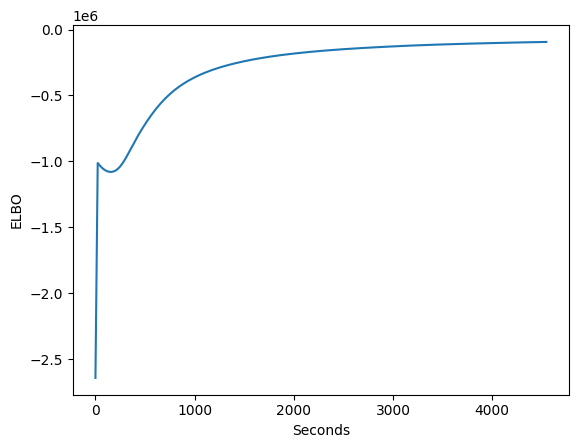

In [479]:
K = 30
V = len(vocab)
ETA = 1 / V
ALPHA = 0.5

tol = 10
iteration = 1
max_iterations = 200
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_matrix=corpus_matrix, K=K, V=V)
ELBOs.append(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_matrix=corpus_matrix, K=K))
while iteration <= max_iterations:
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_matrix=corpus_matrix, K=K)
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_matrix=corpus_matrix, K=K)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)

    if np.abs(curr_ELBO - prev_ELBO) <= tol:
        break

    iteration += 1
    print("\n")

stop = time.time()
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)

In [480]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-10:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

formatted_text = "Top 10 Words for Each Topic:\n\n"
for topic, words in top_words.items():
    formatted_text += f"Topic {topic + 1}: "
    formatted_text += ", ".join(words) + "\n\n"

print(formatted_text)

Top 10 Words for Each Topic:

Topic 1: board, hildreth, company, school, stocks, told, march, prices, week, million

Topic 2: states, years, police, million, friday, told, official, made, court, country

Topic 3: state, cent, new, cents, popeye, march, higher, million, years, futures

Topic 4: today, company, fair, soviet, first, wednesday, city, country, police, news

Topic 5: president, year, today, rambo, tuesday, told, billion, court, judge, made

Topic 6: time, found, increase, name, east, mayor, people, gorbachev, series, soviet

Topic 7: new, first, year, house, tuesday, political, officials, drug, company, office

Topic 8: people, two, time, government, billion, defense, new, last, federal, economic

Topic 9: new, tuesday, people, company, court, billion, american, get, trade, back

Topic 10: year, told, american, today, time, two, monday, soviet, system, drug

Topic 11: year, chrysler, contra, million, ec, last, percent, government, contract, united

Topic 12: state, aquino, p